**Execution time ~1'**

In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scrublet as scr
import os

import sys
sys.path.append('../../')
from scCustomFunctions import *
from pipelines import *

from parameters import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
adata = scp.read("data/raw.h5ad")

#Load to the working matrix the raw counts
adata.X = adata.obsm["Raw"].copy()

# Basic QC measures

We perform a common quality control wiith the following measures:
 
 1. Number of UMI counts per cell
 2. Number of expressed genes per cell
 3. Number of expressing cells per gene
 4. Mitocondrial fraction
 
It is of relevance to notice that the data extracted from Pijuan and Sala already contains some strict cutoffs over the data:

 1. #Counts > 5000
 2. mtFraction < 2.37%

In [3]:
mtGenesPositions = np.array([i for i,j in enumerate(adata.var["Gene"]) if "mt-" in j])

In [4]:
quality_control_metrics(adata,mtGenesPositions)

## UMI counts per cell

The UMI counts had already a high lower cutoff. We do not increase the constrain as it seems to fall in the basin of the bimodality between the removed lower UMI count (<5000) and the proper count distribution.

We do not set any upper bound, in the same way of their analysis. If high count cells are doublets, very probably they will be detected in by the doublet deconvolution procedure we will perform afterwards.

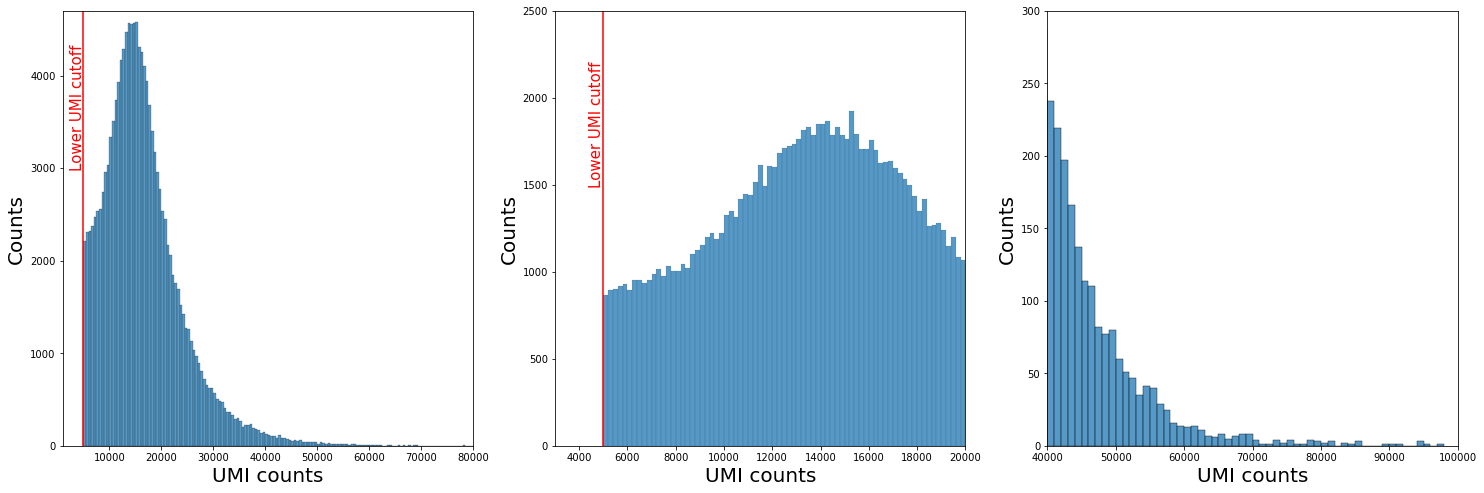

In [5]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

##Counts
i0 = 0; i1 = None;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=500);
ax[i0].axis([1000,80000,0,4700])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-2600,3000,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=200);
ax[i0].axis([3000,20000,0,2500])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=adata.obs,x="#Counts",ax=ax[i0],binwidth=1000);
ax[i0].axis([40000,100000,0,300])
#ax[i0,i1].vlines(mi#Counts,0,5000,color="r")
#ax[i0,i1].text(mi#Counts-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].vlines(MAX_COUNTS,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_UMI_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Gene counts per cell

The number of gene counts show a clear bimodality. This is perfectly normal since the dataset has a very extense variety of cell types with different genetic patterns. We do not constraint at all the distribution at all, as in the analysis of Pijuan and set very loose bounds.


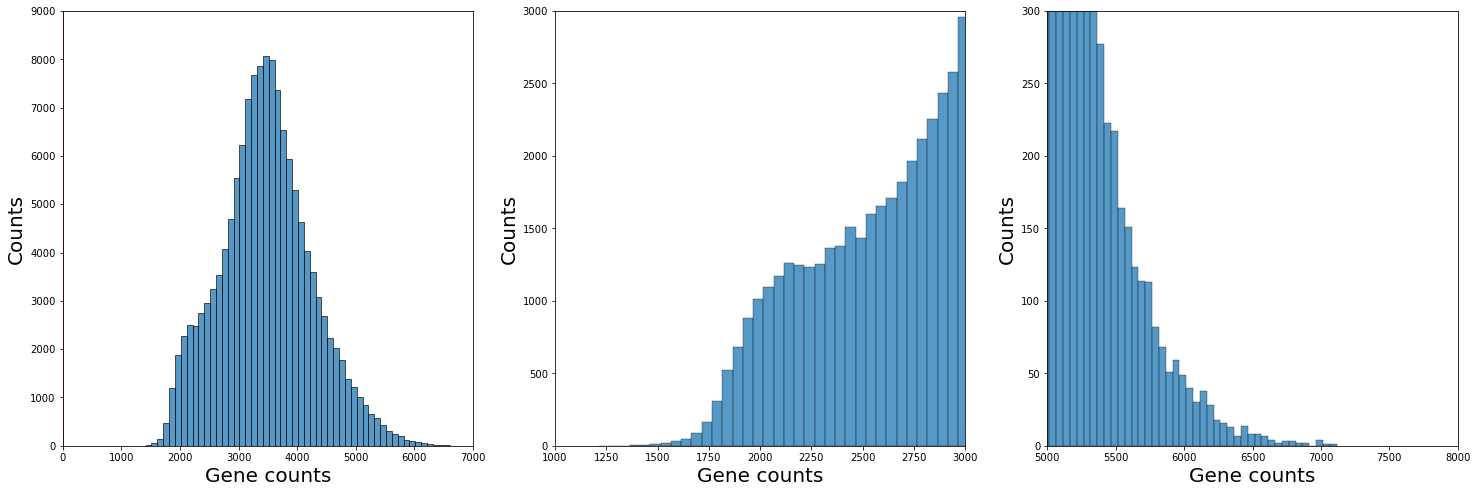

In [6]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

##Genes
i0 = 0; i1 = 0;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=100);
ax[i0].axis([0,7000,0,9000])
ax[i0].vlines(MIN_GENES,0,10000,color="r")
#ax[i0].text(MIN_GENES-300,1500,"Lower #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=50);
ax[i0].axis([1000,3000,0,3000])
ax[i0].vlines(MIN_GENES,0,4000,color="r")
#ax[i0].text(MIN_GENES-100,1500,"Lower #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=adata.obs,x="#Genes",ax=ax[i0],binwidth=50);
ax[i0].axis([5000,8000,0,300])
ax[i0].vlines(MAX_GENES,0,5000,color="r")
#ax[i0].text(MAX_GENES+100,100,"Higher #Genes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_Gene_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Mitochondrial fraction

The dataset has already a predefined upper bound, which will represent dead or dying cells. According to Pijuan's article, after a extremely convoluted process involving clustering the data in a very sloppy way they concluded that they should also remove all cells with a mitochondrial fraction below 0.005.

I consider this process to be very weird and suspicious and simply chose a lower bound according to the bidomal distribution of the mt fraction. This subset if considered to be due to stripped cells, which exploded and only genes from the nuclei are present mostly. 

Although it is clear that there is a subset of cells that show a extremelly low expression of mitochondrial genes, which will be an indicator of stripped cells, in the original work, this fraction is never removed from the system.

In order to stay as close as possible to the results of the original work, **we will not remove the stipped cells at this point**.

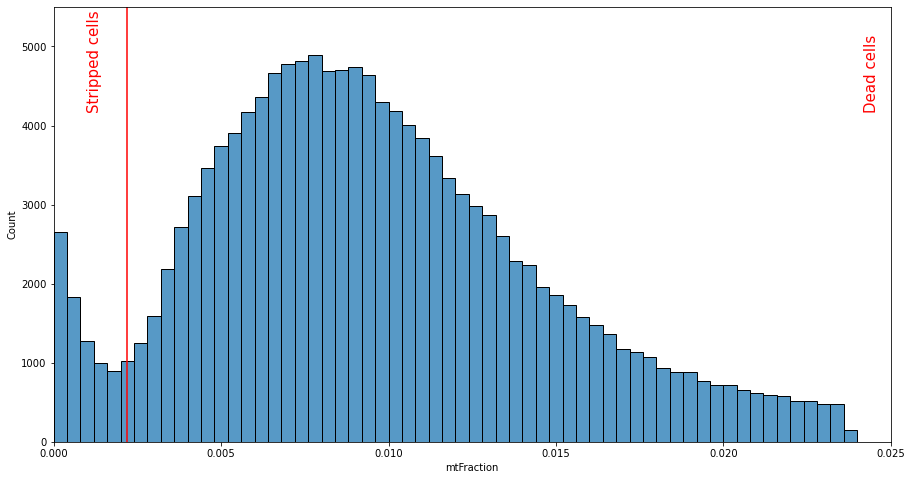

In [7]:
fig,ax = plt.subplots(1,1,figsize=[15,8])

#metFraction
i0 = 3; i1 = 0;
sb.histplot(data=adata.obs,x="mtFraction",ax=ax,binwidth=0.0004);
ax.axis([0,0.025,0,5500])
ax.vlines(MIN_MT_FRACTION,0,6000,color="r")
ax.text(0.001,4200,"Stripped cells",color="red",fontsize=15,rotation="vertical")
ax.vlines(MAX_MT_FRACTION,0,6000,color="r")
ax.text(0.0242,4200,"Dead cells",color="red",fontsize=15,rotation="vertical")

fig.savefig("Plots/1_QC_mt_fraction.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot of the above limits

From the scatter plot it looks like there is a bimodality. This may happen because a certain set of cells have a different gene expression diversity as other cells. We discuss that in a [section below](#Bimodality). 

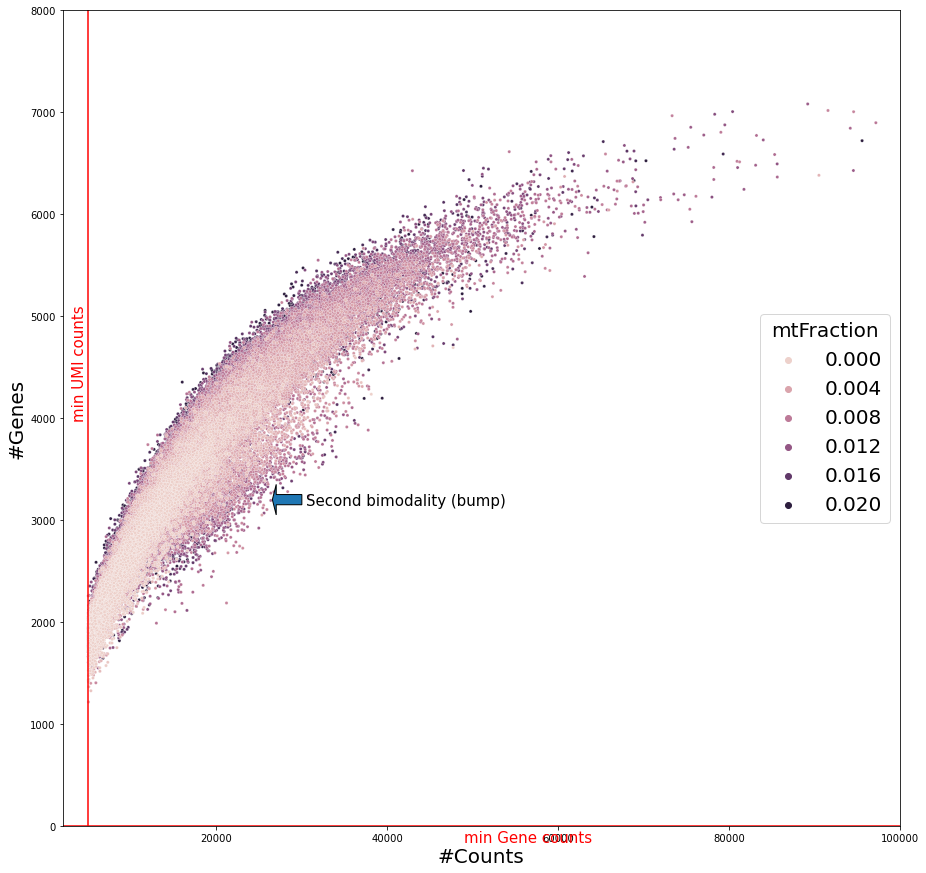

In [8]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 0
data = adata.obs.copy()
data.sort_values("mtFraction",inplace=True,ascending=False)
sb.scatterplot(x="#Counts",y="#Genes",hue="mtFraction",data=data,hue_norm=(0,0.02),ax=ax,s=10)
axis = [2000,100000,0,8000]
ax.legend(frameon=True,loc="center right",fontsize=20,title="mtFraction",title_fontsize=20)
ax.axis(axis)
ax.vlines(MAX_COUNTS,axis[2],axis[3])
#ax.text(maxCounts,5000,"min UMI count",rotation="vertical")
ax.vlines(MIN_COUNTS,axis[2],axis[3],color="r")
ax.text(MIN_COUNTS-(axis[1]-axis[0])*0.02,(axis[3]-axis[2])/2,"min UMI counts",color="r",rotation="vertical",fontsize=15)
#ax.hlines(MAX_GENES,axis[0],axis[1],color="r")
#ax.text((axis[1]-axis[0])/2,MAX_GENES+(axis[3]-axis[2])*0.01,"max Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.hlines(MIN_GENES,axis[0],axis[1],color="r")
ax.text((axis[1]-axis[0])/2,MIN_GENES-(axis[3]-axis[2])*0.02,"min Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.set_xlabel("#Counts",fontsize=20)
ax.set_ylabel("#Genes",fontsize=20)
ax.arrow(30000,3200,-3000,0,width=100)
ax.text(30500,3150,"Second bimodality (bump)",fontsize=15)

fig.savefig("Plots/1_QC_UMI_Genes_scatter.png",bbox_inches="tight",transparent=True)
fig.show()

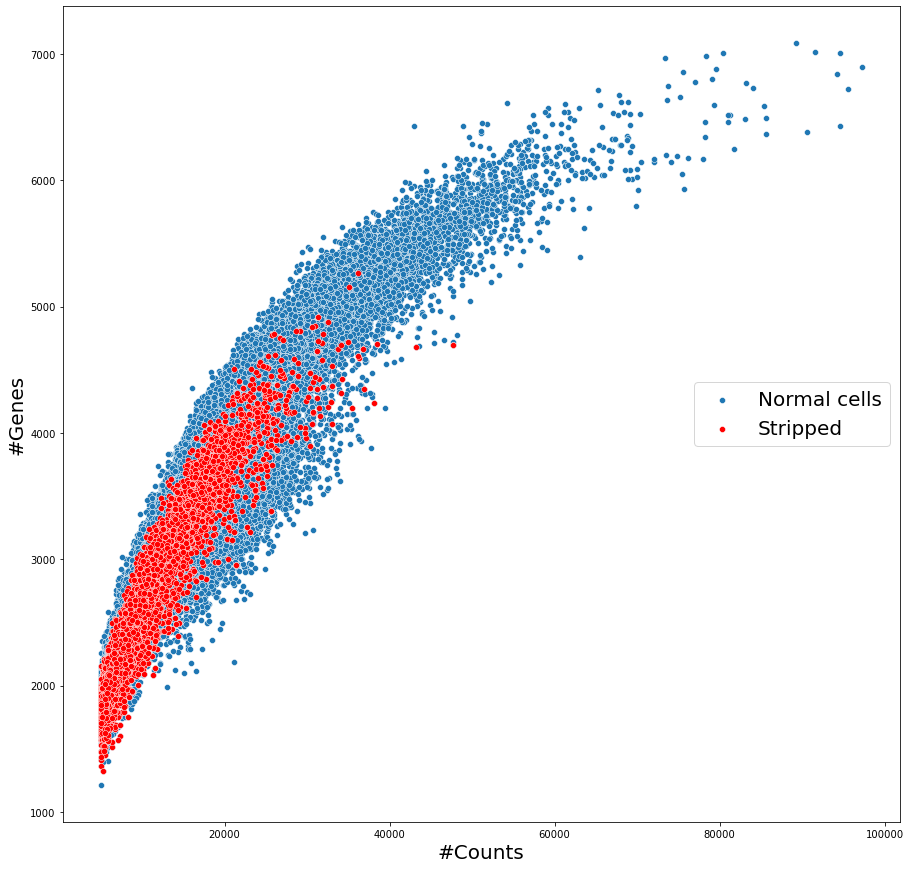

In [9]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 1
sb.scatterplot(x="#Counts",y="#Genes",data=adata.obs,ax=ax)
sb.scatterplot(x="#Counts",y="#Genes",color="r",data=adata.obs[adata.obs["mtFraction"]<MIN_MT_FRACTION],ax=ax)
ax.legend(["Normal cells","Stripped"],frameon=True,loc="center right",fontsize=20)
ax.set_xlabel("#Counts",fontsize=20)
ax.set_ylabel("#Genes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stripped.png",bbox_inches="tight",transparent=True)
fig.show()

## Expressing cells per gene

Since there may be the case that there are very small populations of cells during developmental stages, we will consider a very loose cutoff of the expressing cells and we will remove only those genes that are not expressed at all in the dataset. This is a repetition of the analysis of Pijuan.

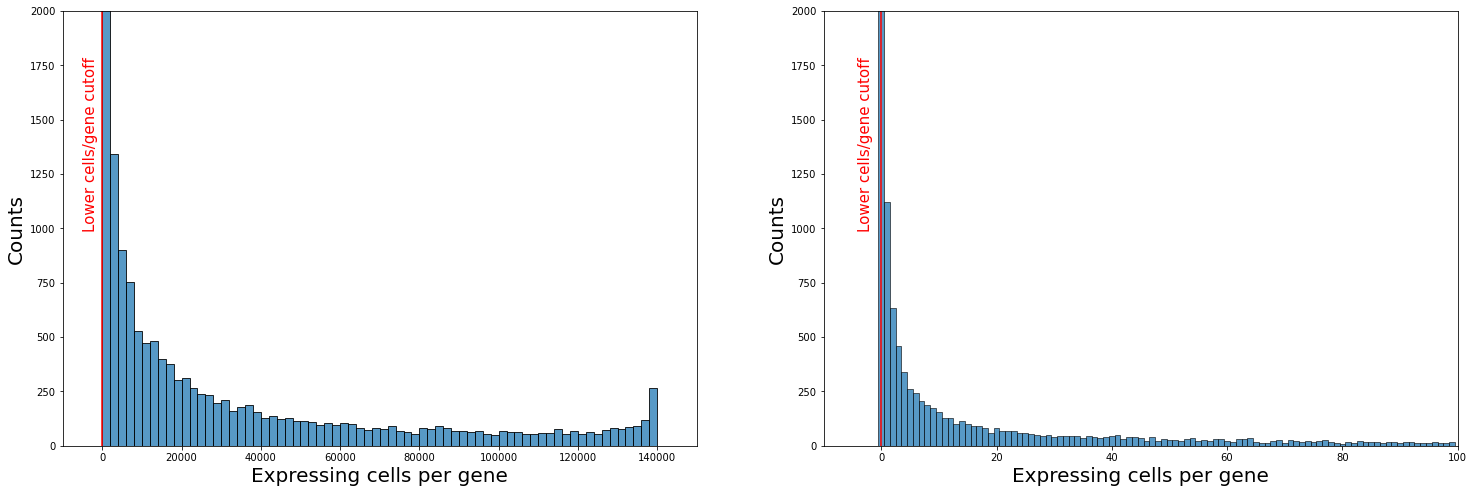

In [10]:
fig,ax = plt.subplots(1,2,figsize=[25,8])

##Cells
i0 = 0;
sb.histplot(data=adata.var,x="#Cells",ax=ax[i0],binwidth=2000);
ax[i0].axis([-10000,150000,0,2000])
ax[i0].vlines(MIN_GENES,0,5000,color="r")
ax[i0].text(-5000,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

##Cells
i0 = 1;
sb.histplot(data=adata.var,x="#Cells",ax=ax[i0],bins=np.arange(-.5,100.5,1));
ax[i0].axis([-10,100,0,2000])
ax[i0].vlines(MIN_GENES,0,5000,color="r")
ax[i0].text(-4,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_Cell_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by samples

We do a quality check over the different samples of the dataset.

From their preprocessing, they already eliminated one sample (11) because showed an anomalous number of cells. But we keep it for sake of consistency with the preprocessing performed in the original paper.

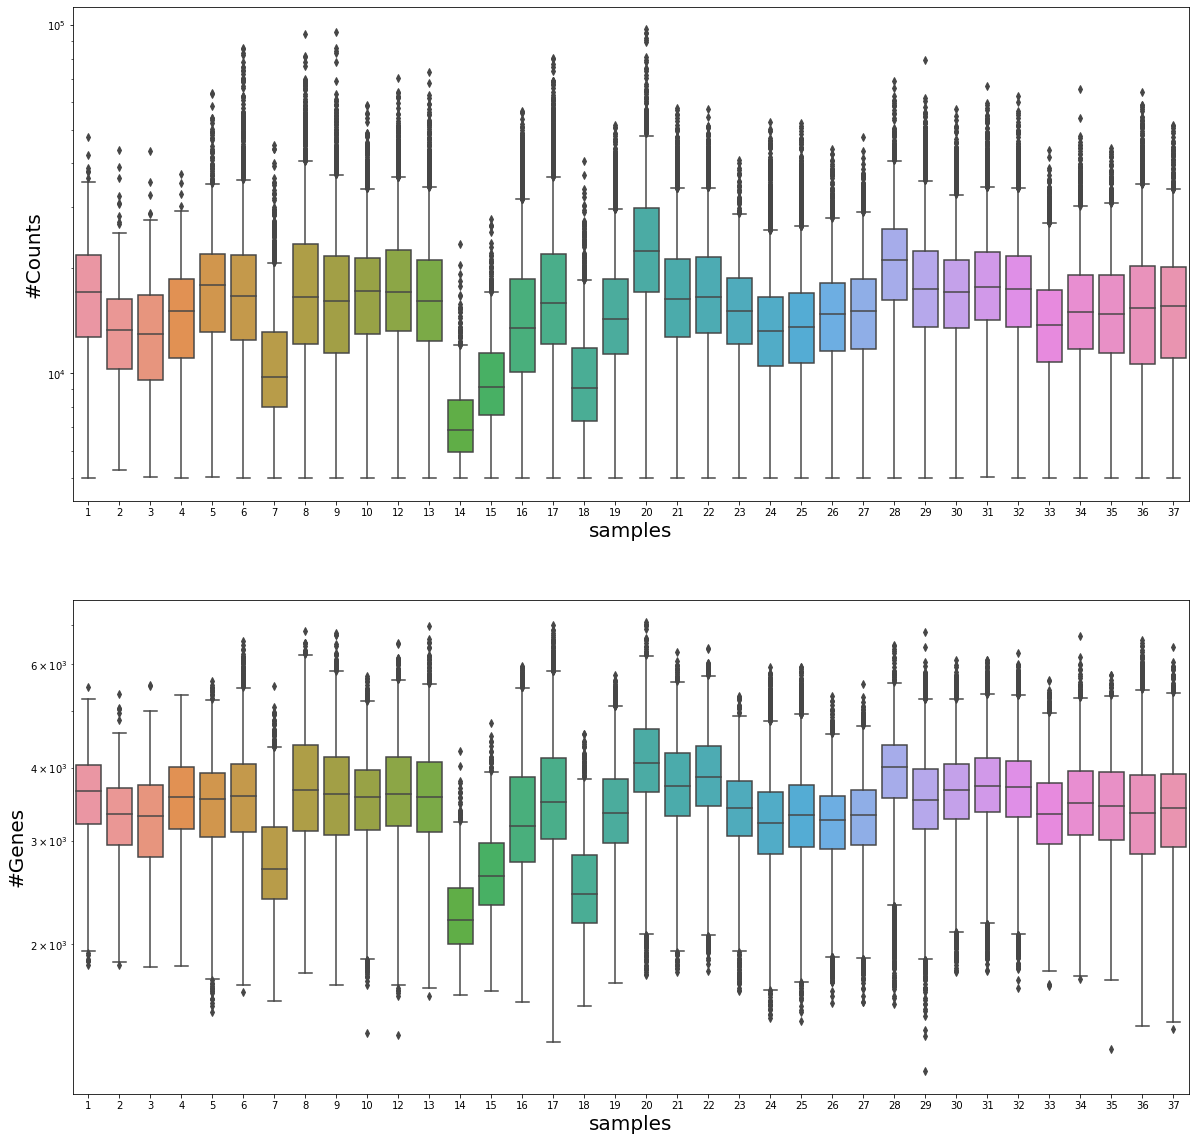

In [11]:
fig,ax = plt.subplots(2,1,figsize=[20,20])

sb.boxplot(y="#Counts",x="Sample",data=adata.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("#Counts",fontsize=20)

sb.boxplot(y="#Genes",x="Sample",data=adata.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("#Genes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_sample.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by stages

When plotting against the stages, there does not seem to be bias on the expression and count levels.

In [ ]:
fig,ax = plt.subplots(3,1,figsize=[20,20])

sb.violinplot(y="#Counts",x="Stage",data=adata.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("#Counts",fontsize=20)

sb.violinplot(y="#Genes",x="Stage",data=adata.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("#Genes",fontsize=20)

sb.violinplot(y="mtFraction",x="Stage",data=adata.obs,ax=ax[2])
ax[2].set_xlabel("samples",fontsize=20)
ax[2].set_ylabel("mtFraction",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stage.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot bimodality 

As in Pijuan, we look at the gene Hbb-bh1, which is an indicator of blod cell lines. As it can be seen, the second bump in the scatter plot comes from cells expressing the blod cell line indicator and start appearing from the later stages of the development. 

Blod cells show a lower diversity of genes, which is represented in the plots by the second modality at a lower gene expression. This confirms that we are not runing into technical artifacts with the datadata.

In [ ]:
samp = np.sort(adata.obs["Stage"].values.unique())

fig,ax=plt.subplots(3,3,figsize=[25,25])
m = np.meshgrid(range(3),range(3))
hue = np.log(np.array(adata[:,adata.var["Gene"]=="Hbb-bh1"].X.todense()).reshape(-1)+1)
for i,j in zip(m[0].reshape(9),m[1].reshape(9)):
    k = 3*i+j
    l = adata.obs["Stage"]==samp[k]
    sb.scatterplot(x="#Counts",y="#Genes",hue=hue[l],hue_norm=(0,10),data=adata.obs[l],ax=ax[i,j])
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    ax[i,j].set_title(str(samp[k]),fontsize=20)#,loc='lower right')
    
fig.text(0.5, 0.08, '#Genes', ha='center', fontsize=40)
fig.text(0.08, 0.5, '#Counts', va='center', rotation='vertical', fontsize=40)

fig.savefig("Plots/1_QC_Second_bimodality.png",bbox_inches="tight",transparent=True)
fig.show()

# Doublets

In this stage we will remove all the cells that have high likelihood of being doublets.

Moreover, since the doublet scoring process is stochastic and prone to leave outliers, we further remove cells that have a high number of neighbors being doublets.

## Compute doublet scores

### Scrublet

In [ ]:
scrublet_pipeline(adata,
                batch_key="Sample",
                normalize=True,
                target_sum=adata.obs["#Counts"].mean(),
                log_normalize=True,
                feature_reduction_flavor="seurat",
                n_retained_features=None,
                exclude_genes=SKIP_GENES,
                key_exclude_list="Gene",
                n_prin_components = 50,
                knn_dist_metric="correlation",
                key_added="Scrublet_score",
                doublet_statistics_file="results/Scrublet_doublet_scores",
                verbose=False)

## Simulated doublet statistics

In [ ]:
data = pd.read_csv("results/Scrublet_doublet_scores")

fig, ax = plt.subplots(1,1,figsize=[30,10])
sns.violinplot(data=data,x="Sample",y="doublet_score_sim")
ax.hlines(DOUBLET_SCORE_MAX_THRESHOLD,-1,36,linewidth=5,zorder=10,color="red")
ax.set_ylabel("Simulated Doublet Scores",fontsize=20)
ax.set_xlabel("Sample",fontsize=20)

# Dimensionality reduction

In [ ]:
# Normalize to the mean total
scp.pp.normalize_total(adata,target_sum=adata.obs.loc[:,"#Counts"].mean())
# Lognormalize
scp.pp.log1p(adata)

In [ ]:
dimensionality_reduction_pipeline(adata)

### UMAPs by stages

In [ ]:
neighbors_batches(adata,use_rep="X_pca_Stage",metric=METRIC)

In [ ]:
umap_batches(adata,neighbors_key="neighbors_Stage")

In [ ]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),figsize=[10,10*len(adata.obs["Stage"].unique())])

for i,stage in enumerate(adata.obs["Stage"].unique()):
    
    l = adata.obs.loc[:,"Stage"]==stage
    
    order = np.argsort(adata.obs.loc[l,"Sample"].values.astype(str))
    hue = np.sort(adata.obs.loc[l,"Sample"].values.astype(str))
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][order],adata.obsm["X_umap_Stage"][l,1][order],hue=hue,s=10,ax=ax[i])
    ax[i].set_title("Stage "+stage,fontsize=30)

## Batch correction

### Harmony

In [ ]:
harmony_integrate_batches(adata,verbose=False)

### Corrected UMAPs by stages

In [ ]:
neighbors_batches(adata,add_key="neighbors_Harmony_Stage",use_rep="X_pca_Harmony_Stage",metric=METRIC)

In [ ]:
umap_batches(adata,neighbors_key="neighbors_Harmony_Stage")

In [ ]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),figsize=[10,10*len(adata.obs["Stage"].unique())])

for i,stage in enumerate(adata.obs["Stage"].unique()):
    
    l = adata.obs.loc[:,"Stage"]==stage
    
    order = np.argsort(adata.obs.loc[l,"Sample"].values.astype(str))
    hue = np.sort(adata.obs.loc[l,"Sample"].values.astype(str))
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][order],adata.obsm["X_umap_Stage"][l,1][order],hue=hue,s=10,ax=ax[i])
    ax[i].set_title("Stage "+stage,fontsize=30)

# Imputed cells

In [ ]:
adata.obs.loc[:,"Imputed"] = (adata.obs.loc[:,"mtFraction"] < MIN_MT_FRACTION) + (adata.obs.loc[:,"Scrublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD)

### UMAP imputed cells

In [ ]:
fig,ax= plt.subplots(len(adata.obs["Stage"].unique()),5,figsize=[50,10*len(adata.obs["Stage"].unique())])

data = pd.read_csv("./data/raw/meta.tab",sep="\t",skiprows=0)

for i,stage in enumerate(adata.obs["Stage"].unique()):
        
    ax[i,2].legend(["Retained","Stripped","Doublet"])
    ax[i,0].set_ylabel("Stage "+stage,fontsize=30)
    
    l = adata.obs.loc[:,"Stage"]==stage    

    hue = adata.obs.loc[l,"mtFraction"]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],hue=hue,s=30,ax=ax[i,0])

    hue = adata.obs.loc[l,"Scrublet_score"]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],hue=hue,s=30,ax=ax[i,1])
    
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,2])
    stripped = adata.obs.loc[l,"mtFraction"] < MIN_MT_FRACTION
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,2])
    stripped = adata.obs.loc[l,"Scrublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,2])

    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,3])
    stripped = adata.obs.loc[l,"mtFraction"] < MIN_MT_FRACTION
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,3])
    stripped = adata.obs.loc[l,"Scrublet_score"] > .1#DOUBLET_SCORE_MAX_THRESHOLD
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,3])
    
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0],adata.obsm["X_umap_Stage"][l,1],s=30,ax=ax[i,4])
    stripped = data.loc[:,"stripped"].values[l]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="red",s=30,ax=ax[i,4])
    stripped = data.loc[:,"doublet"].values[l]
    sb.scatterplot(adata.obsm["X_umap_Stage"][l,0][stripped],adata.obsm["X_umap_Stage"][l,1][stripped],color="black",s=30,ax=ax[i,4])

ax[0,0].set_title("mtFraction",fontsize=30)
ax[0,1].set_title("Scrublet",fontsize=30)
ax[0,2].set_title("Our analysis (doublet threshold .2)",fontsize=30)
ax[0,3].set_title("Our analysis (doublet threshold .1)",fontsize=30)
ax[0,4].set_title("Pijuan-Sala",fontsize=30)

### Compare cells imputed by Pijuan-Sala and our analysis

In [ ]:
adata.obs.loc[:,"Imputed"] = (adata.obs.loc[:,"mtFraction"] < MIN_MT_FRACTION) + (adata.obs.loc[:,"Scrublet_score"] > .2)

In [ ]:
data = pd.read_csv("./data/raw/meta.tab",sep="\t",skiprows=0)

d = pd.DataFrame(columns=["All","All_Ab","aB","Stage","Pijuan","Us","Us (.1)"])
for i,stage in enumerate(adata.obs["Stage"].unique()):
    l = (adata.obs["Stage"]==stage).values
    
    Ab = np.sum((data.loc[l,"doublet"]+data.loc[l,"stripped"]).values*np.invert(adata.obs.loc[l,"Imputed"]).values)
    aB = np.sum(np.invert(data.loc[l,"doublet"]+data.loc[l,"stripped"]).values*(adata.obs.loc[l,"Imputed"]).values)
    AB = np.sum((data.loc[l,"doublet"]+data.loc[l,"stripped"]).values*(adata.obs.loc[l,"Imputed"]).values)
    t = np.sum(l)
    
    p = ((data.loc[l,"doublet"]+data.loc[l,"stripped"])).sum()
    us = adata.obs.loc[l,"Imputed"].sum()
    us2 = np.sum((adata.obs.loc[l,"mtFraction"] < MIN_MT_FRACTION) + (adata.obs.loc[l,"Scrublet_score"] > .1))
    
    d.loc[stage,:] = [(Ab+aB+AB)/t,(aB+AB)/t,aB/t,stage,p/t,us/t,us2/t]

In [ ]:
fig,ax = plt.subplots(1,2,figsize=[30,10])

m = d.iloc[:,-4:].melt(id_vars=["Stage"]).rename(columns=str.title)
sb.barplot(x="Stage",y="Value",hue="Variable",data=m,ax=ax[0])

sb.barplot(x=d.index,y="All",data=d,color="red",ax=ax[1])
sb.barplot(x=d.index,y="All_Ab",data=d,color="blue",ax=ax[1])
sb.barplot(x=d.index,y="aB",data=d,color="green",ax=ax[1])
ax[1].legend(["Marioni red","Common blue","Ours green"])

fig.show()

## Remove imputed cells and recompute dimensionality reduction procedure

In [ ]:
adata = adata[adata.obs["Imputed"] == False]

In [ ]:
dimensionality_reduction_pipeline(adata)

In [ ]:
harmony_integrate_batches(adata,verbose=False)

In [ ]:
neighbors_batches(adata,use_rep="X_pca_Stage",metric=METRIC)

In [ ]:
umap_batches(adata,neighbors_key="neighbors_Stage")

# Save data

In [ ]:
adata.write("data/qc.h5ad");